In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Conv1D, GlobalMaxPooling1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import nltk
import re
import string
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from keras.layers import Dense, Embedding, LSTM, Bidirectional
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# load the dataset
df_true = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/True.csv")
df_fake = pd.read_csv("/kaggle/input/fake-and-real-news-dataset/Fake.csv")

In [ ]:
# creating target variable
df_true['label'] = 1
df_fake['label'] = 0

# concatenating in one single dataframe
df = df_true.append(df_fake)
df = df.sample(frac=1).reset_index(drop=True)

df.head()

/tmp/ipykernel_32/1587008257.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_true.append(df_fake)


,title,text,subject,date,label
0,BOOM! Dodgers Baseball Radio Legend Drops A Mi...,This is totally out of left field! Vin Scully ...,politics,"Jun 19, 2016",0
1,Anonymous Posts Video Of Donald Trump That Sh...,Donald Trump has shown his true colors time an...,News,"April 12, 2016",0
2,Trump’s new EPA transition team draws from oil...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,"January 24, 2017",1
3,(VIDEO) TREY GOWDY GETS REAL AT COMMUNITY POLI...,,politics,"May 20, 2015",0
4,Fear of Iranian general left Iraqi Kurdish oil...,BAGHDAD/LONDON (Reuters) - When the Iraqi army...,worldnews,"October 25, 2017",1


In [ ]:
df.isna().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [ ]:
df['text'] = df['title'] + " " + df['text']
df = df[['text', 'label']]
df = df.reset_index(drop=True)
df.head()

,text,label
0,BOOM! Dodgers Baseball Radio Legend Drops A Mi...,0
1,Anonymous Posts Video Of Donald Trump That Sh...,0
2,Trump’s new EPA transition team draws from oil...,1
3,(VIDEO) TREY GOWDY GETS REAL AT COMMUNITY POLI...,0
4,Fear of Iranian general left Iraqi Kurdish oil...,1


In [ ]:
df.isna().sum()

text     0
label    0
dtype: int64

In [ ]:
new_df=df.copy()

In [ ]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [ ]:
new_df['text']=new_df['text'].apply(lambda x:review_cleaning(x))
new_df.head()

,text,label
0,boom dodgers baseball radio legend drops a mid...,0
1,anonymous posts video of donald trump that sh...,0
2,trump’s new epa transition team draws from oil...,1
3,video trey gowdy gets real at community polici...,0
4,fear of iranian general left iraqi kurdish oil...,1


In [ ]:
stop = stopwords.words('english')
new_df['text'] = new_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
new_df.head()

,text,label
0,boom dodgers baseball radio legend drops midga...,0
1,anonymous posts video donald trump shows crazy...,0
2,trump’s new epa transition team draws oil indu...,1
3,video trey gowdy gets real community policing ...,0
4,fear iranian general left iraqi kurdish oil fi...,1


In [ ]:
max_words = 5000
maxlen = 100
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(new_df['text'])
sequences = tokenizer.texts_to_sequences(new_df['text'])
X = pad_sequences(sequences, maxlen=maxlen)
y = new_df['label']
y = pd.get_dummies(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# CNN

In [ ]:
model = Sequential()
model.add(Embedding(max_words, 128, input_length=maxlen))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 96, 64)            41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 681,154
Trainable params: 681,154
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
562/562 [==============================] - 58s 84ms/step - loss: 0.1485 - accuracy: 0.9492 - val_loss: 0.0519 - val_accuracy: 0.9816
Epoch 2/5
562/562 [==============================] - 13s 23ms/step - loss: 0.0256 - accuracy: 0.9924 - val_loss: 0.0384 - val_accuracy: 0.9873
Epoch 3/5
562/562 [==============================] - 11s 19ms/step - loss: 0.0068 - accuracy: 0.9989 - val_loss: 0.0408 - val_accuracy: 0.9886
Epoch 4/5
562/562 [==============================] - 7s 12ms/step - loss: 0.0017 - accuracy: 0.9998 - val_loss: 0.0424 - val_accuracy: 0.9878
Epoch 5/5
562/562 [==============================] - 6s 10ms/step - loss: 5.5727e-04 - accuracy: 1.0000 - val_loss: 0.0440 - val_accuracy: 0.9875


In [ ]:
# wt = model.get_layer().get_weights()[0]
# wt[0]

In [ ]:
y_pred0 = model.predict(X_test)
y_pred0 = [1 if x[1]>0.5 else 0 for x in y_pred0]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred0))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred0))

281/281 [==============================] - 1s 2ms/step
Accuracy: 0.9874164810690423
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4619
           1       0.99      0.99      0.99      4361

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred0)
cm_cv

array([[4565,   54],
       [  59, 4302]])

In [ ]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

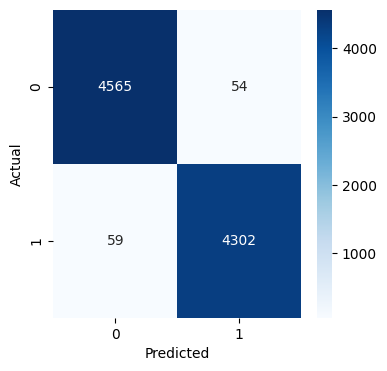

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# LSTM

In [ ]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, 128, input_length=maxlen))
model_lstm.add(LSTM(64,dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(2, activation='sigmoid'))

In [ ]:
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 128)          640000    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 689,538
Trainable params: 689,538
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_lstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
562/562 [==============================] - 329s 579ms/step - loss: 0.1201 - accuracy: 0.9533 - val_loss: 0.0479 - val_accuracy: 0.9854
Epoch 2/5
562/562 [==============================] - 307s 547ms/step - loss: 0.0308 - accuracy: 0.9907 - val_loss: 0.0477 - val_accuracy: 0.9850
Epoch 3/5
562/562 [==============================] - 304s 541ms/step - loss: 0.0181 - accuracy: 0.9950 - val_loss: 0.0413 - val_accuracy: 0.9884
Epoch 4/5
562/562 [==============================] - 302s 538ms/step - loss: 0.0147 - accuracy: 0.9956 - val_loss: 0.0415 - val_accuracy: 0.9884
Epoch 5/5
562/562 [==============================] - 302s 538ms/step - loss: 0.0078 - accuracy: 0.9979 - val_loss: 0.0413 - val_accuracy: 0.9879


In [ ]:
y_pred1 = model_lstm.predict(X_test)
y_pred1 = [1 if x[1]>0.5 else 0 for x in y_pred1]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred1))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred1))

281/281 [==============================] - 11s 39ms/step
Accuracy: 0.987750556792873
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4619
           1       0.99      0.98      0.99      4361

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred1)
cm_cv

array([[4581,   38],
       [  72, 4289]])

In [ ]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

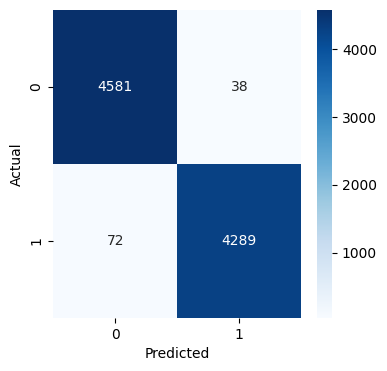

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')

# Bi-Lstm

In [ ]:
model_bilstm = Sequential()
model_bilstm.add(Embedding(max_words, 128, input_length=maxlen))
model_bilstm.add(Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dense(2, activation='sigmoid'))

In [ ]:
model_bilstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
model_bilstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 128)          640000    
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_1 (Dense)             (None, 2)                 258       
                                                                 
Total params: 739,074
Trainable params: 739,074
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_bilstm.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
562/562 [==============================] - 623s 1s/step - loss: 0.1228 - accuracy: 0.9546 - val_loss: 0.0482 - val_accuracy: 0.9853
Epoch 2/5
562/562 [==============================] - 595s 1s/step - loss: 0.0291 - accuracy: 0.9911 - val_loss: 0.0350 - val_accuracy: 0.9900
Epoch 3/5
562/562 [==============================] - 593s 1s/step - loss: 0.0204 - accuracy: 0.9936 - val_loss: 0.0440 - val_accuracy: 0.9890
Epoch 4/5
562/562 [==============================] - 592s 1s/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.0377 - val_accuracy: 0.9900
Epoch 5/5
562/562 [==============================] - 589s 1s/step - loss: 0.0052 - accuracy: 0.9986 - val_loss: 0.0461 - val_accuracy: 0.9883


In [ ]:
y_pred2 = model_bilstm.predict(X_test)
y_pred2 = [1 if x[1]>0.5 else 0 for x in y_pred2]

# Evaluate the model
print("Accuracy:", accuracy_score(y_test.iloc[:,1], y_pred2))
print('Classification Report:')
print(classification_report(y_test.iloc[:,1], y_pred2))

281/281 [==============================] - 22s 77ms/step
Accuracy: 0.9884187082405346
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4619
           1       0.99      0.98      0.99      4361

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



In [ ]:
cm_cv = confusion_matrix(y_test.iloc[:,1],y_pred2)
cm_cv

array([[4583,   36],
       [  68, 4293]])

In [ ]:
cm_cv = pd.DataFrame(cm_cv, index=[0,1], columns=[0,1])
cm_cv.index.name = 'Actual'
cm_cv.columns.name = 'Predicted'

<AxesSubplot: xlabel='Predicted', ylabel='Actual'>

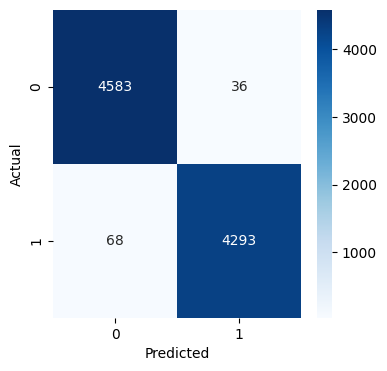

In [ ]:
plt.figure(figsize = (4,4))
sns.heatmap(cm_cv,cmap= "Blues",annot = True, fmt='')